*David Schlangen, 2019-04-17*

# C02 - Getting to know the data 

In [29]:
from __future__ import division
import codecs
import json
import ConfigParser
import sys
import os
from glob import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
from textwrap import fill


%matplotlib inline

import pandas as pd
from IPython.display import display

In [16]:
# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, code_icorpus

In [9]:
sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

In [11]:
# display some lines from each DataFrame found in the preprocessing directory

overview_df = []

df = {}

for this_df_path in glob(os.path.join(preproc_path, '*.json.gz')):
    this_df = os.path.basename(this_df_path).split('.')[0]
    
    df_loaded = pd.read_json(this_df_path, typ='frame', orient='split', compression='gzip')

    df[this_df] = df_loaded
    
    print '-' * 20, this_df, '-' * 20
    #print ''
    #print 'n rows: {:,}'.format(len(df_loaded))
    overview_df.append((this_df, len(df_loaded)))
    #display(df_loaded.head(5))
    #print ''

print '=' * 20, 'Summary', '=' * 20
display(pd.DataFrame(overview_df, columns='name rows'.split()))

-------------------- flickr_bbdf --------------------
-------------------- grex_refdf --------------------
-------------------- cub_capdf --------------------
-------------------- cocoent_objdf --------------------
-------------------- saiapr_bbdf --------------------
-------------------- vqa --------------------
-------------------- cococapdf --------------------
-------------------- cub_attrdf --------------------
-------------------- cocogrprops_bbdf --------------------
-------------------- vgvqadf --------------------
-------------------- cub_partdf --------------------
-------------------- ade_imgdf --------------------
-------------------- ade_objdf --------------------
-------------------- cocoent_capdf --------------------
-------------------- saiapr_refdf --------------------
-------------------- vgobjdf --------------------
-------------------- vgimgdf --------------------
-------------------- mscoco_bbdf --------------------
-------------------- refcoco_refdf --------------

name     rows
0         flickr_bbdf   275775
1          grex_refdf    95010
2           cub_capdf   117870
3       cocoent_objdf  1182608
4         saiapr_bbdf    99534
5                 vqa   658111
6           cococapdf   414113
7          cub_attrdf   371011
8    cocogrprops_bbdf    17184
9             vgvqadf  1445322
10         cub_partdf   141395
11          ade_imgdf    19733
12          ade_objdf   550545
13      cocoent_capdf   592881
14       saiapr_refdf   120081
15            vgobjdf  3895567
16            vgimgdf   108077
17        mscoco_bbdf   604907
18      refcoco_refdf   142210
19              vd_df  1253510
20              gw_df   821889
21           cub_bbdf    11787
22       flickr_objdf   559767
23          ade_reldf   146392
24            vgpardf    19561
25            vgattdf  1674166
26       flickr_capdf   158915
27  refcocoplus_refdf   141564
28            vgreldf  2324859
29      mscoco_catsdf       80
30            vgregdf  5406592

In [12]:
df.keys()

[u'vgobjdf',
 u'refcocoplus_refdf',
 u'cocoent_objdf',
 u'ade_reldf',
 u'ade_objdf',
 u'ade_imgdf',
 u'vqa',
 u'cub_capdf',
 u'vgpardf',
 u'vgregdf',
 u'gw_df',
 u'cub_attrdf',
 u'cub_partdf',
 u'cub_bbdf',
 u'refcoco_refdf',
 u'cococapdf',
 u'saiapr_refdf',
 u'flickr_objdf',
 u'vgattdf',
 u'cocogrprops_bbdf',
 u'flickr_bbdf',
 u'mscoco_catsdf',
 u'mscoco_bbdf',
 u'cocoent_capdf',
 u'vgvqadf',
 u'vgreldf',
 u'flickr_capdf',
 u'vd_df',
 u'saiapr_bbdf',
 u'grex_refdf',
 u'vgimgdf']

In [6]:
# Load mapping from category ID to category name
saiapr_cat_path = os.path.join(config.get('SAIAPR', 'saiapr_base'),
                               'SAIA_Data/benchmark/wlist.txt')

saiapr_cat = {}
with open(saiapr_cat_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        saiapr_cat[int(row[0])] = row[1]

## SAIAPR TC-12: Holiday Pictures

IAPR TC-12 is a collection of  “20,000 still natural images taken from locations around the world and comprising an assorted cross-section of still natural images” \cite{Grubinger2006}. This dataset was later augmented by \cite{Escalante2010} with segmentation masks identifying objects in the images (an average of 5 objects per image). It was further augmented by \cite{Kazemzadeh2014} with expressions referring to objects in the images. (This annotation will be discussed elsewhere.)

Here's an example of an object-annotated image from the corpus. (Note that the corpus actually provides segmentation masks, which are tight boundaries around the objects. For simplicity, and since most modern methods actually take rectangular image patches as input, this is extended in our preprocessing to the smallest box that contains all pixels.) 

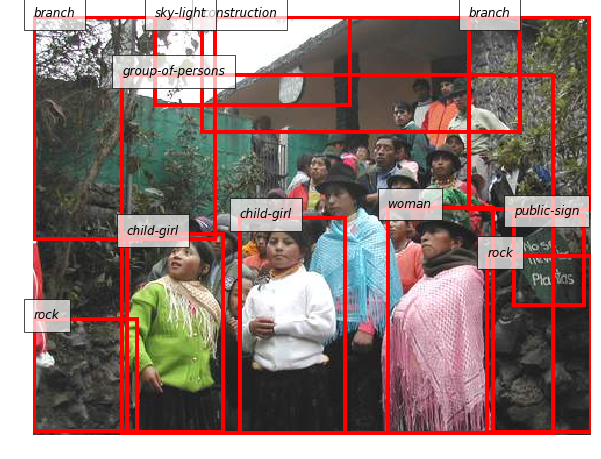

In [13]:
# Plot one image from the corpus, together with bounding boxes around segmented objects.
ii = 112
ic = icorpus_code['saiapr']
bbs = [(bb, saiapr_cat[cat_id]) 
       for bb, cat_id in query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'cat']).values]
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

In [14]:
saiapr_cat

{1: '',
 2: 'aerostatic-balloon',
 3: 'air-vehicles',
 4: 'airplane',
 5: 'ancent-building',
 6: 'animal',
 7: 'ant',
 8: 'antelope',
 9: 'ape',
 10: 'apple',
 11: 'arctic',
 12: 'astronaut',
 13: 'baby',
 14: 'ball',
 15: 'balloon',
 16: 'beach',
 17: 'bear',
 18: 'beaver',
 19: 'bed',
 20: 'beetle',
 21: 'bench',
 22: 'bicycle',
 23: 'bird',
 24: 'boat',
 25: 'boat-rafting',
 26: 'bobcat-wildcat',
 27: 'book',
 28: 'bottle',
 29: 'branch',
 30: 'bridge',
 31: 'building',
 32: 'bull',
 33: 'bus',
 34: 'bush',
 35: 'butterfly',
 36: 'cabin',
 37: 'cactus',
 38: 'camel',
 39: 'camera',
 40: 'can',
 41: 'canine',
 42: 'cannon',
 43: 'car',
 44: 'caribou',
 45: 'castle',
 46: 'cat',
 47: 'caterpillar',
 48: 'cello',
 49: 'chair',
 50: 'cheetah',
 51: 'child',
 52: 'child-boy',
 53: 'child-girl',
 54: 'chimney',
 55: 'church',
 56: 'church-interior',
 57: 'city',
 58: 'clock',
 59: 'cloth',
 60: 'cloud',
 61: 'column',
 62: 'construction',
 63: 'construction-other',
 64: 'coral',
 65: 'cou

In [19]:
df['saiapr_bbdf'].head(20)

i_corpus  image_id  region_id                   bb  cat
0          0       112          1   [76, 50, 371, 308]  120
1          0       112          2     [0, 260, 89, 96]  204
2          0       112          3  [390, 206, 89, 151]  204
3          0       112          4     [0, 0, 156, 191]   29
4          0       112          5   [374, 0, 104, 165]   29
5          0       112          6    [145, 0, 273, 99]   62
6          0       112          7  [305, 164, 90, 194]  273
7          0       112          8  [177, 173, 91, 185]   53
8          0       112          9   [80, 187, 83, 170]   53
9          0       112         10   [413, 170, 60, 78]  195
10         0       112         11    [104, 0, 168, 76]  225
11         0       116          1   [344, 18, 76, 178]  160
12         0       116          2    [171, 2, 57, 152]  160
13         0       116          3     [0, 0, 478, 359]  118
14         0       116          4   [92, 177, 260, 96]  204
15         0        25          1     [0, 0, 323, 324]   29
16         0        25          2   [255, 2, 192, 173]   60
17         0        25          3  [86, 143, 392, 171]   31
18         0        25          4   [227, 65, 38, 267]  254
19         0        25          5    [402, 3, 74, 327]  182

In [17]:
code_icorpus[0]

'saiapr'

In [20]:
df['mscoco_bbdf'].head()

i_corpus  image_id  region_id                               bb  cat
0         1    480023         86  [116.95, 305.86, 285.3, 266.03]   58
1         1     50518         89    [245.54, 208.17, 40.14, 19.1]   58
2         1    142589         93    [288.4, 18.07, 211.6, 331.33]   58
3         1    209263        113    [126.5, 475.24, 77.68, 76.73]   58
4         1     15307        116   [185.57, 93.4, 219.97, 420.29]   58

In [21]:
get_image_filename(config, ic, ii)

u'/Volumes/SSD_500/Corpora/External/ImageCorpora/IAPR_ReferIt/SAIA_Data/benchmark/saiapr_tc-12/00/images/112.jpg'

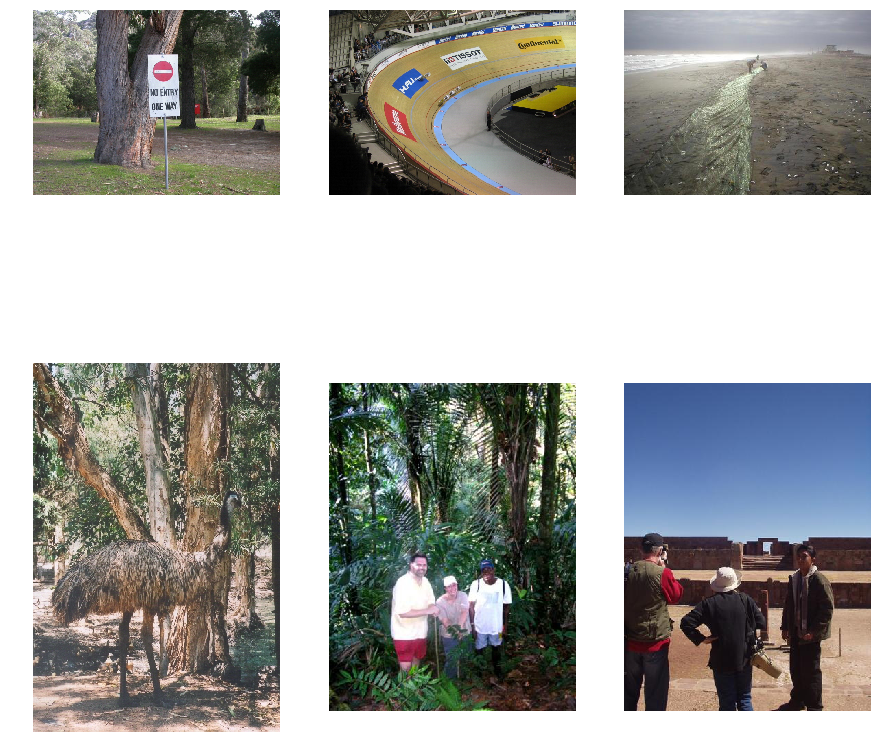

In [27]:
# A random sample of 6 images from SAIAPR
all_iis = df['saiapr_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'saiapr', ii)

Caption: a girl wearing flip-flop sandals swinging on a swing set in a park underneath
fluffy white clouds .

With groundings:
[/EN#3883/people A girl] wearing [/EN#3889/clothing flip-flop sandals] swinging
on [/EN#3884/other a swing] set in [/EN#3887/scene a park] underneath
[/EN#3890/other fluffy white clouds] .


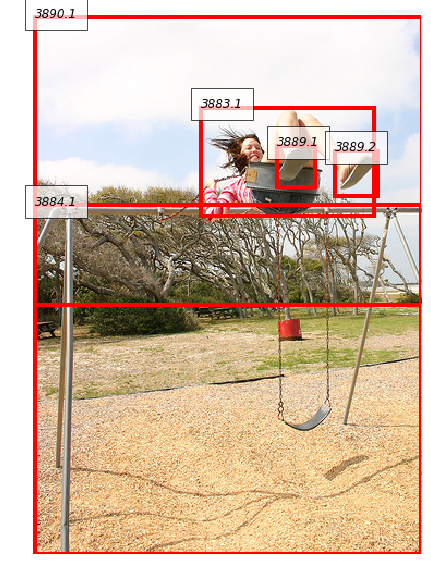

In [30]:
# example of a Flickr30k caption, with a randomly selected negative example
def flcap2bb(cap_row, bbdf):
    cap = cap_row['caption_raw'] # cap_row['caption_annotated']
    entities = cap_row['entities']
    outbb = []
    for entity in entities:
        this_bb = bbdf[bbdf['region_id'] == entity]
        for _, row in this_bb.iterrows():
            outbb.append((row['bb'], '%d.%d' % (entity, row['subregion_id'])))
    # outbb.append(([0,0,10,10], fill(cap, 40)))
    return outbb

pick_row = 2345
this_row = df['flickr_capdf'].iloc[pick_row]
ii = this_row['image_id']
print 'Caption:', fill(this_row['caption_raw'], 80)
print ''
print 'With groundings:\n', fill(this_row['caption_annotated'], 80)
plot_labelled_bb(get_image_filename(config, 8, ii),
                 flcap2bb(this_row, df['flickr_bbdf']), figsize=(10,10))

In [31]:
df['flickr_bbdf'].head()

i_corpus    image_id  region_id  subregion_id                   bb
0         8  1000092795          1             1  [159, 125, 60, 210]
1         8  1000092795          4             1   [1, 220, 210, 253]
2         8  1000092795          4             2  [276, 215, 56, 122]
3         8  1000092795          1             2  [197, 110, 64, 263]
4         8  1000092795          5             1  [207, 144, 50, 100]

In [32]:
df['flickr_capdf'].head()

i_corpus    image_id                                  caption_annotated  \
0         8  1000092795  [/EN#1/people Two young guys] with [/EN#2/body...   
1         8  1000092795  [/EN#1/people Two young , White males] are out...   
2         8  1000092795  [/EN#1/people Two men] in [/EN#5/clothing gree...   
3         8  1000092795  [/EN#6/people A man] in [/EN#7/clothing a blue...   
4         8  1000092795  [/EN#1/people Two friends] enjoy [/EN#10/other...   

                                         caption_raw      entities  
0  two young guys with shaggy hair look at their ...  [1, 2, 3, 8]  
1  two young , white males are outside near many ...        [1, 4]  
2   two men in green shirts are standing in a yard .     [1, 5, 9]  
3       a man in a blue shirt standing in a garden .     [6, 7, 9]  
4            two friends enjoy time spent together .       [1, 10]

In [33]:
df['flickr_capdf'][:10]['caption_raw'].apply(len)

0    83
1    54
2    48
3    44
4    39
5    62
6    57
7    48
8    37
9    26
Name: caption_raw, dtype: int64

In [34]:
df['flickr_objdf'].head()

i_corpus    image_id  region_id                   phrase        cat
0         8  1000092795          1           Two young guys     people
1         8  1000092795          2              shaggy hair  bodyparts
2         8  1000092795          3              their hands  bodyparts
3         8  1000092795          8                 the yard      scene
4         8  1000092795          1  Two young , White males     people

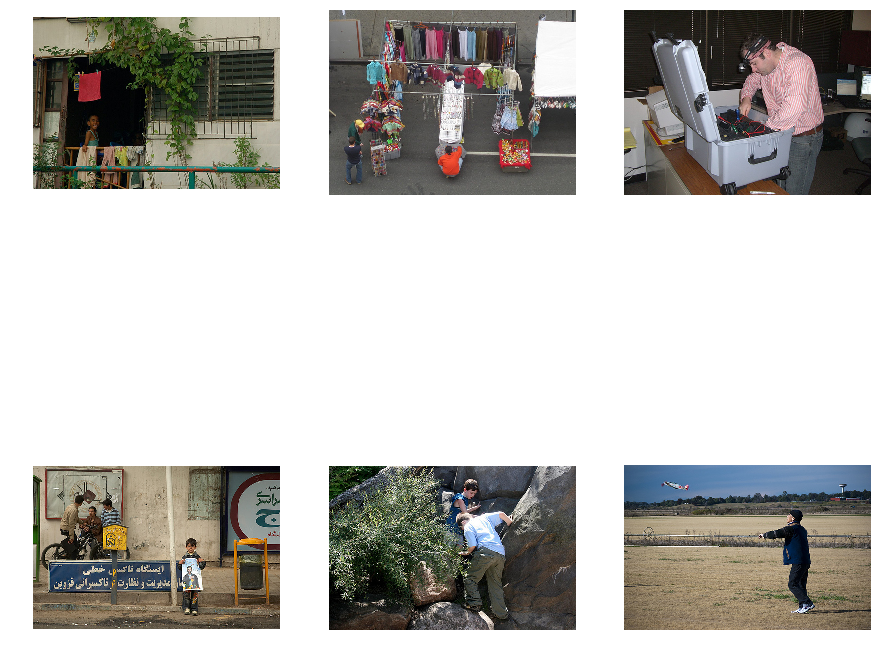

In [36]:
# A random sample of 6 images from SAIAPR
all_iis = df['flickr_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'flickr_30k', ii)

## MS-COCO: Common Objects in Context

The “Microsoft Common Objects in Context ([MSCOCO](http://cocodataset.org/#home))” collection \cite{mscoco} contains over 300k images with object segmentations (of objects from 80 pre-specified categories), object labels, and image captions. It forms the basis of a large number of subsequent works that added all kinds of further annotations, such as complex expressions referring to one of the objects, or questions about the images, or even sequence of questions and answers. We will again discuss some of that additional material in `03_Tasks`, focussing on the original annotation here.

This dataset was constructed with the objects being in focus. The list of 80 "common objects" from various object classes (see below) was created first, and with pairs of object name and common scene type, Flickr was queried for images.

In [37]:
df['mscoco_catsdf']['supercat'].value_counts()

sports        10
food          10
animal        10
vehicle        8
indoor         7
kitchen        7
electronic     6
furniture      6
accessory      5
appliance      5
outdoor        5
person         1
Name: supercat, dtype: int64

A woman prepares several sub sandwiches at a deli counter.
a person behind a display glass preparing food 
A lady behind a sneeze guard making sub sandwiches.
THERE IS A WOMAN THAT IS MAKING SANDWICHES AT A DELI
A woman behind a deli counter making sub sandwiches.


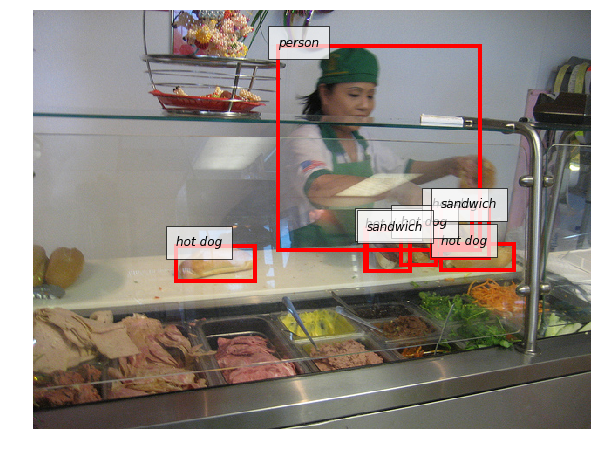

In [38]:
# plot mscoco categories on image
pick_row = 100

# easier to look up:
cococat = dict(zip(df['mscoco_catsdf'].index, df['mscoco_catsdf']['cat'].values))

ic, ii  = df['mscoco_bbdf'].iloc[pick_row][['i_corpus', 'image_id']]

for cap in query_by_id(df['cococapdf'], (icorpus_code['mscoco'], ii), 'caption'):
    print cap

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), ['bb', 'cat']).values
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, cococat[cat]) for b, cat in this_anno])

In [39]:
df['cococapdf'].head()

caption   id  image_id  i_corpus
0     A very clean and well decorated empty bathroom   48    318556         1
1  A panoramic view of a kitchen and all of its a...   67    116100         1
2  A blue and white bathroom with butterfly theme...  126    318556         1
3     A panoramic photo of a kitchen and dining room  148    116100         1
4  A graffiti-ed stop sign across the street from...  173    379340         1

In [40]:
get_image_filename(config, 1, 318556)

u'/Volumes/SSD_500/Corpora/External/ImageCorpora/MSCOCO/COCO/train2014/COCO_train2014_000000318556.jpg'

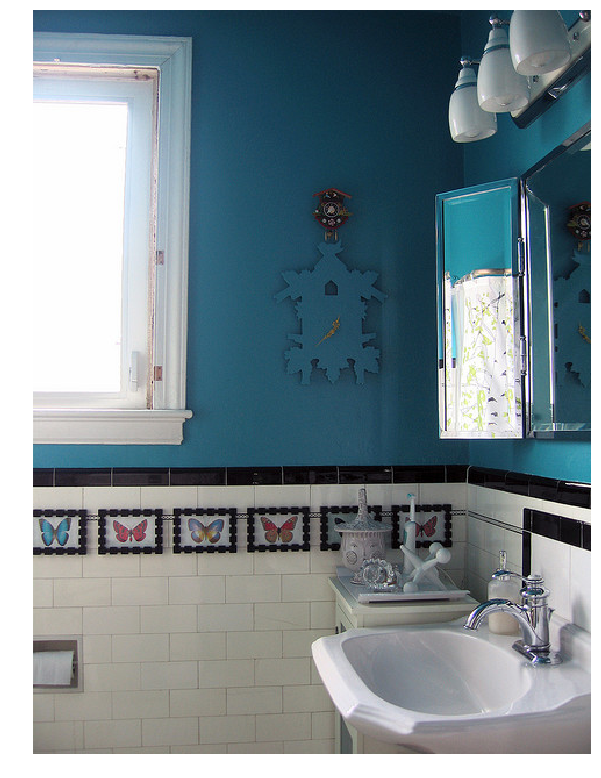

In [41]:
plot_labelled_bb(get_image_filename(config, 1, 318556), [])